In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

# More distribution objects

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline

2022-03-12 16:52:14.815510: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-12 16:52:14.815545: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [74]:
probs = np.r_[[.8,.3,.5]]

b = tfp.distributions.Bernoulli(probs=probs)
b

<tfp.distributions.Bernoulli 'Bernoulli' batch_shape=[3] event_shape=[] dtype=int32>

In [75]:
s = b.sample(100000).numpy()
s.shape

(100000, 3)

In [76]:
s

array([[1, 1, 0],
       [1, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [1, 1, 0]], dtype=int32)

In [77]:
np.mean(s, axis=0)

array([0.80058, 0.29994, 0.49951])

## The [`Categorical`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical) distribution

- **Last dimension** of `probs` is the number of classes
- The **rest of dimensions** is the `batch_shape`

In [80]:
probs = np.r_[[[.1,.4,.5],[10,6,4]]]
probs.shape

(2, 3)

In [81]:
c = tfd.Categorical(probs=probs)
c

<tfp.distributions.Categorical 'Categorical' batch_shape=[2] event_shape=[] dtype=int32>

In [83]:
s = c.sample(1000000).numpy()
print (s, "\n", s.shape)

[[2 0]
 [1 2]
 [1 1]
 ...
 [1 0]
 [1 1]
 [2 1]] 
 (1000000, 2)


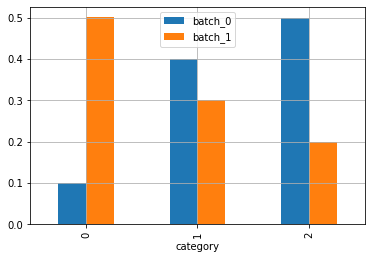

In [84]:
# frequencies observed in the sample must match the unnormalized probabilities.
pd.DataFrame([pd.Series(s[:,i]).value_counts()/len(s) for i in range(s.shape[1])], 
             index = [f"batch_{i}" for i in range(s.shape[1])]).T.plot(kind='bar')
plt.xlabel("category")
plt.grid();

In [96]:
# the categorical with two classes equivalen to the Bernoulli above

probs = np.r_[[[.2,.7,.5],
               [.8,.3,.5]]].T
c = tfd.Categorical(probs=probs)
print (c)
s = c.sample(1000000).numpy()
print (s, s.shape)

tfp.distributions.Categorical("Categorical", batch_shape=[3], event_shape=[], dtype=int32)
[[1 0 1]
 [1 0 0]
 [1 0 1]
 ...
 [0 1 0]
 [0 0 0]
 [0 0 1]] (1000000, 3)


In [97]:
s.mean(axis=0)

array([0.799924, 0.300756, 0.499514])

## A [`Mixture`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Mixture) distribution

- a `Categorical` distribution acts as a selector
- a **list** of distributions to select from

In [98]:
mix = 0.3
bimix_gauss = tfd.Mixture(
    cat=tfd.Categorical(probs=[mix, 1.-mix]),
    components=[
      tfd.Normal(loc=-1, scale=0.3),
      tfd.Normal(loc=+1., scale=1.),
    ],
    validate_args = True)
bimix_gauss

<tfp.distributions.Mixture 'Mixture' batch_shape=[] event_shape=[] dtype=float32>

In [99]:
s = bimix_gauss.sample(100000).numpy()
s.shape

(100000,)

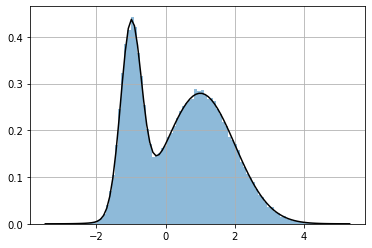

In [100]:
xr = np.linspace(np.min(s), np.max(s), 100)
plt.hist(s, bins=100, density=True, alpha=.5);
plt.plot(xr, np.exp(bimix_gauss.log_prob(xr)), color="black")
plt.grid();